In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset (handling the duplicate column names issue automatically)
df = pd.read_excel('/content/finalDataset0.2.xlsx')

# The dataset structure is: Column N (Text), Column N+1 (Label)
# Let's map the pairs manually to ensure accuracy
aspect_map = {
    'Teaching': [1, 0], # Swapped: Review Text (1), Sentiment (0)
    'Course Content': [3, 2], # Swapped: Review Text (3), Sentiment (2)
    'Examination': [5, 4], # Swapped: Review Text (5), Sentiment (4)
    'Lab Work': [7, 6], # Swapped: Review Text (7), Sentiment (6)
    'Library Facilities': [9, 8], # Swapped: Review Text (9), Sentiment (8)
    'Extracurricular': [11, 10] # Swapped: Review Text (11), Sentiment (10)
}

reshaped_data = []

# Iterate through rows and extract data by aspect pairs
for index, row in df.iterrows():
    for aspect, cols in aspect_map.items():
        text_col_idx = cols[0]
        label_col_idx = cols[1]

        # Check if indices are within bounds
        if label_col_idx < len(df.columns) and text_col_idx < len(df.columns):
            review_text = row.iloc[text_col_idx]
            sentiment = row.iloc[label_col_idx]

            # clean out empty rows
            if pd.notna(review_text) and pd.notna(sentiment):
                reshaped_data.append({
                    'Aspect': aspect,
                    'Review': str(review_text).strip(),
                    'Sentiment': int(sentiment) # Ensure sentiment is cast to int correctly
                })

# Create the master dataframe
long_df = pd.DataFrame(reshaped_data)

# Display the first few rows of our clean, structured data
print("Data Successfully Restructured:")
print(long_df.head())

Data Successfully Restructured:
               Aspect                                             Review  \
0            Teaching  teacher are punctual but they should also give...   
1      Course Content                     content of courses are average   
2         Examination                        examination pattern is good   
3            Lab Work  not satisfactory, lab work must include latest...   
4  Library Facilities  library facilities are good but number of book...   

   Sentiment  
0          0  
1          0  
2          1  
3         -1  
4          0  


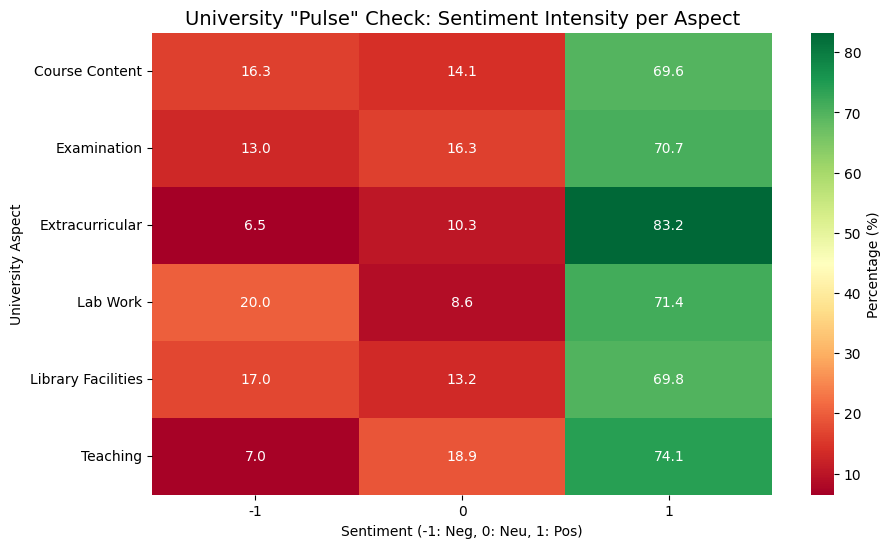

In [9]:
# Create a pivot table for the heatmap
sentiment_summary = long_df.groupby(['Aspect', 'Sentiment']).size().unstack(fill_value=0)

# Calculate percentages for better comparison
sentiment_pct = sentiment_summary.div(sentiment_summary.sum(axis=1), axis=0) * 100

plt.figure(figsize=(10, 6))
sns.heatmap(sentiment_pct, annot=True, fmt=".1f", cmap="RdYlGn", cbar_kws={'label': 'Percentage (%)'})
plt.title('University "Pulse" Check: Sentiment Intensity per Aspect', fontsize=14)
plt.xlabel('Sentiment (-1: Neg, 0: Neu, 1: Pos)')
plt.ylabel('University Aspect')
plt.show()

In [10]:
from collections import Counter
import re

def get_top_pain_points(aspect_name, df):
    # Filter for negative sentiment in the specific aspect
    negative_reviews = df[(df['Aspect'] == aspect_name) & (df['Sentiment'] == -1)]['Review']

    # Simple cleaning and tokenization
    all_text = " ".join(negative_reviews).lower()
    # Remove basic punctuation
    all_text = re.sub(r'[^\w\s]', '', all_text)
    words = all_text.split()

    # Filter out boring stop words
    stop_words = set(['the', 'is', 'and', 'to', 'of', 'in', 'are', 'not', 'but', 'for', 'a', 'they'])
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]

    return Counter(filtered_words).most_common(5)

# Innovative Output: Automated Insight Generation
aspects_to_check = ['Library Facilities', 'Examination', 'Lab Work']

print("--- 🚨 CRITICAL PAIN POINTS DETECTED 🚨 ---")
for aspect in aspects_to_check:
    top_issues = get_top_pain_points(aspect, long_df)
    print(f"\nArea: {aspect}")
    print(f"Students are complaining about: {', '.join([word[0] for word in top_issues])}")

--- 🚨 CRITICAL PAIN POINTS DETECTED 🚨 ---

Area: Library Facilities
Students are complaining about: books, library, available, some, required

Area: Examination
Students are complaining about: should, good, exam, examination, very

Area: Lab Work
Students are complaining about: lab, practical, marks, that, very


/tmp/ipython-input-1403094635.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ranking['NSS'], y=ranking.index, palette="viridis")


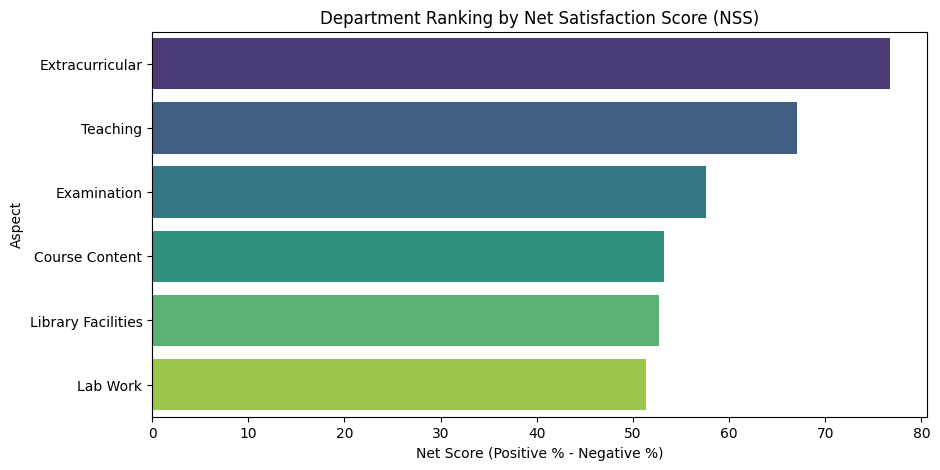

In [13]:
# Calculate Net Satisfaction Score
sentiment_pct['NSS'] = sentiment_pct[1] - sentiment_pct[-1]

# Sort by best performing
ranking = sentiment_pct.sort_values('NSS', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=ranking['NSS'], y=ranking.index, palette="viridis")
plt.title('Department Ranking by Net Satisfaction Score (NSS)')
plt.xlabel('Net Score (Positive % - Negative %)')
plt.axvline(0, color='red', linestyle='--') # The danger line
plt.show()

In [14]:
diverging_data = sentiment_pct[[-1, 0, 1]].reset_index()
diverging_data[-1] = diverging_data[-1] * -1
diverging_data.rename(columns={-1: 'Negative', 0: 'Neutral', 1: 'Positive'}, inplace=True)

print("Prepared Data for Diverging Chart:")
print(diverging_data.head())

Prepared Data for Diverging Chart:
Sentiment              Aspect   Negative    Neutral   Positive
0              Course Content -16.304348  14.130435  69.565217
1                 Examination -13.043478  16.304348  70.652174
2             Extracurricular  -6.486486  10.270270  83.243243
3                    Lab Work -20.000000   8.648649  71.351351
4          Library Facilities -17.032967  13.186813  69.780220


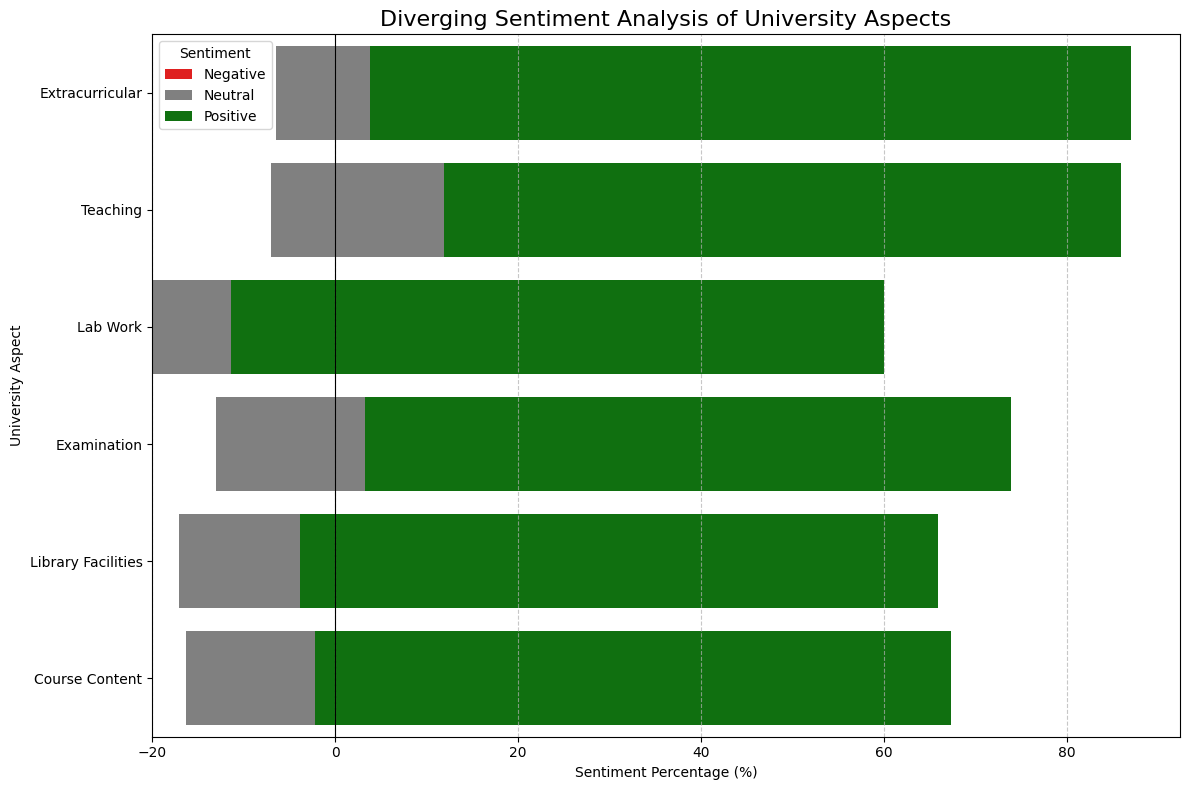

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the data by Positive sentiment for better visualization
diverging_data_sorted = diverging_data.sort_values(by='Positive', ascending=False)

plt.figure(figsize=(12, 8))

# Create a stacked bar chart
sns.barplot(x='Negative', y='Aspect', data=diverging_data_sorted, color='red', label='Negative')
sns.barplot(x='Neutral', y='Aspect', data=diverging_data_sorted, left=diverging_data_sorted['Negative'], color='grey', label='Neutral')
sns.barplot(x='Positive', y='Aspect', data=diverging_data_sorted, left=diverging_data_sorted['Negative'] + diverging_data_sorted['Neutral'], color='green', label='Positive')

plt.xlabel('Sentiment Percentage (%)')
plt.ylabel('University Aspect')
plt.title('Diverging Sentiment Analysis of University Aspects', fontsize=16)
plt.legend(title='Sentiment')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.axvline(0, color='black', linestyle='-', linewidth=0.8)

plt.tight_layout()
plt.show()

/tmp/ipython-input-1756773027.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x='Sentiment', y='WordCount', data=df_long, palette="viridis")


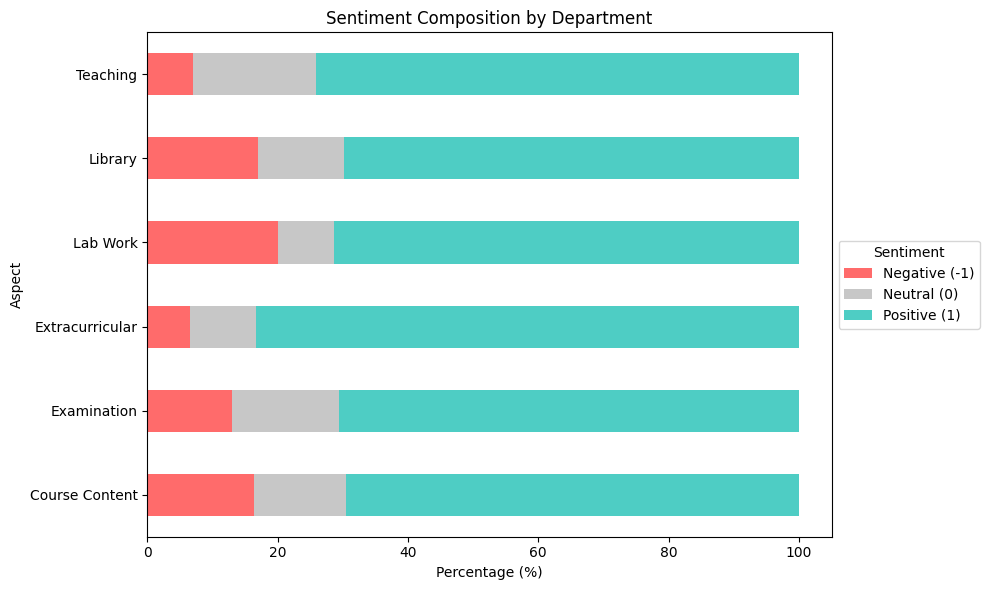

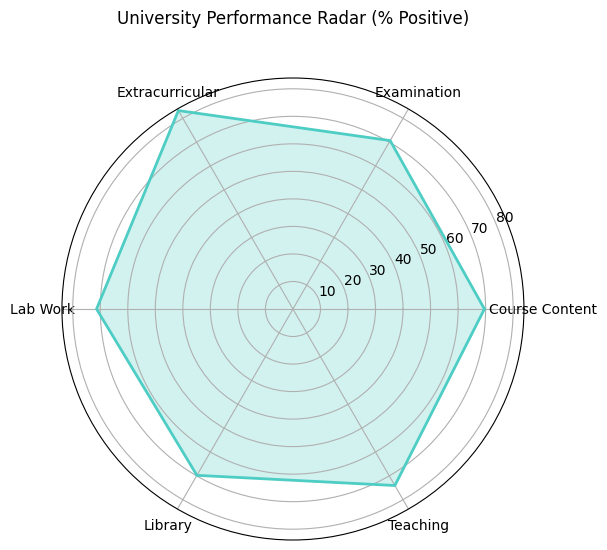

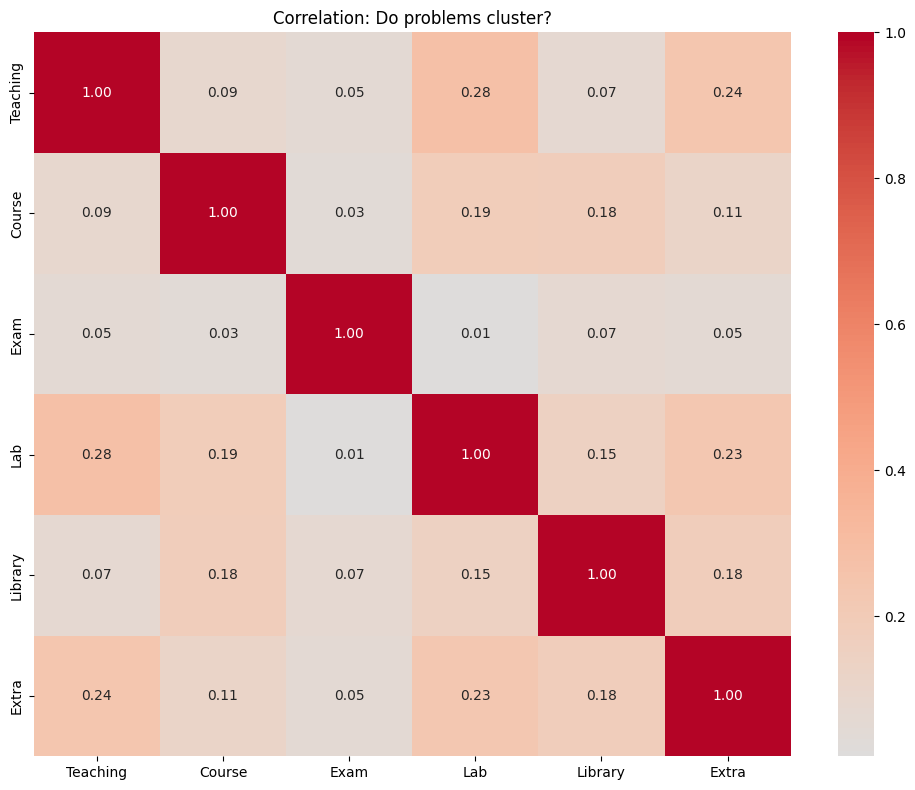

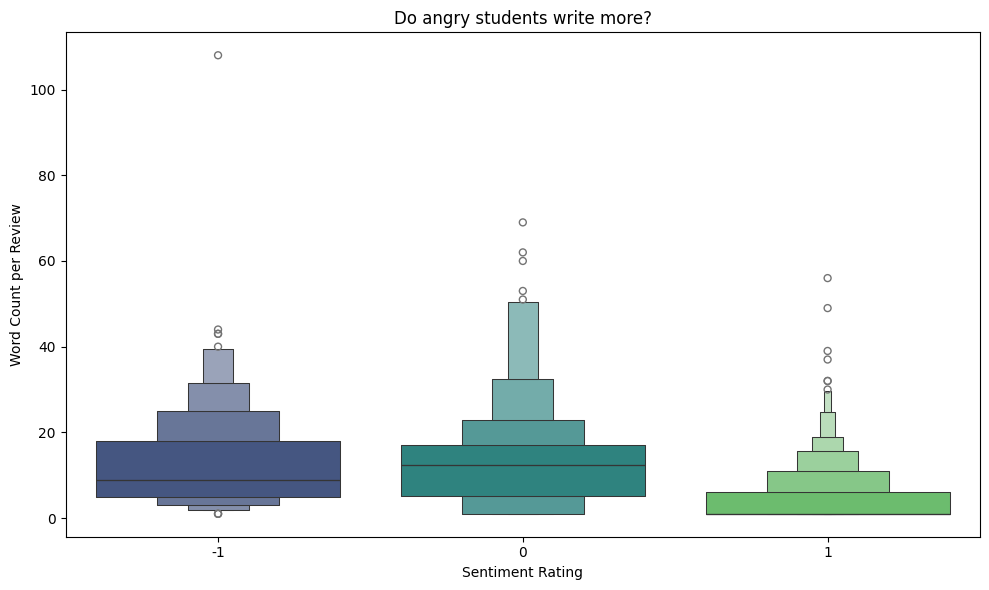

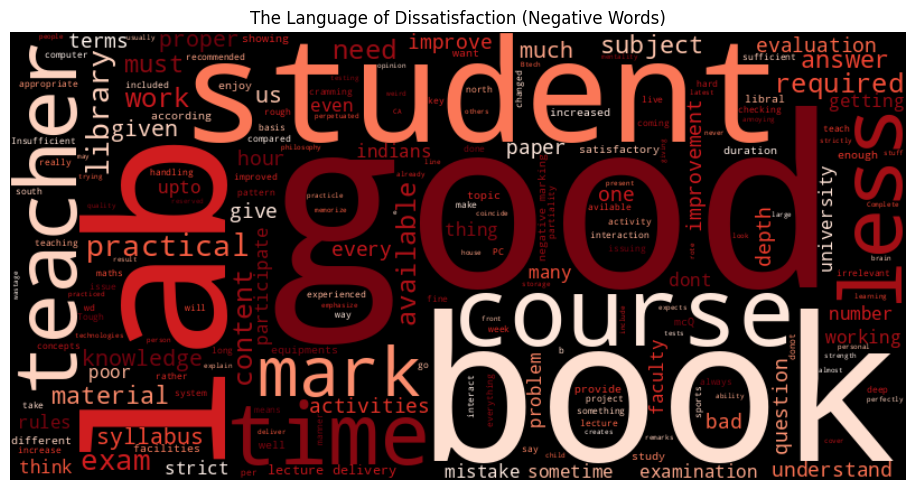

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. DATA LOADING & RESTRUCTURING
# -------------------------------
# Corrected file name to .xlsx and using read_excel
df = pd.read_excel('finalDataset0.2.xlsx')

# Map columns: (Label Index, Text Index)
# In this dataset, labels (numeric) appear in the even columns and text in the odd columns
aspect_pairs = {
    'Teaching': (0, 1),
    'Course Content': (2, 3),
    'Examination': (4, 5),
    'Lab Work': (6, 7),
    'Library': (8, 9),
    'Extracurricular': (10, 11)
}

long_data = []
for idx, row in df.iterrows():
    for aspect, (label_idx, text_idx) in aspect_pairs.items():
        try:
            val = row.iloc[label_idx]
            # Convert to numeric (handles strings or floats)
            val = float(val)
            if not np.isnan(val):
                long_data.append({
                    'Aspect': aspect,
                    'Sentiment': int(val),
                    'Review': str(row.iloc[text_idx]),
                    'WordCount': len(str(row.iloc[text_idx]).split())
                })
        except:
            continue

df_long = pd.DataFrame(long_data)

# 2. GENERATING THE 5 VISUALIZATIONS
# ----------------------------------

# Viz 1: Sentiment Composition (Stacked Bar)
pivot = df_long.groupby(['Aspect', 'Sentiment']).size().unstack(fill_value=0)
# Ensure columns -1, 0, 1 exist for the plot colors mapping
for s in [-1, 0, 1]:
    if s not in pivot.columns:
        pivot[s] = 0
pivot = pivot[[-1, 0, 1]] # Sort columns for consistency

pivot_pct = pivot.div(pivot.sum(axis=1), axis=0) * 100
colors = ['#FF6B6B', '#C7C7C7', '#4ECDC4'] # Red (Neg), Grey (Neu), Teal (Pos)

plt.figure(figsize=(10, 6))
pivot_pct.plot(kind='barh', stacked=True, color=colors, ax=plt.gca())
plt.title('Sentiment Composition by Department')
plt.xlabel('Percentage (%)')
plt.legend(title='Sentiment', labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('sentiment_composition.png')

# Viz 2: The "Positivity" Radar
radar_val = pivot_pct[1] # Take only Positive %
labels = radar_val.index.tolist()
stats = radar_val.values.tolist()
stats += stats[:1] # Close the loop
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='#4ECDC4', alpha=0.25)
ax.plot(angles, stats, color='#4ECDC4', linewidth=2)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('University Performance Radar (% Positive)', y=1.1)
plt.savefig('performance_radar.png')

# Viz 3: Correlation Matrix
numeric_indices = [0, 2, 4, 6, 8, 10]
numeric_df = df.iloc[:, numeric_indices].copy()
numeric_df.columns = ['Teaching', 'Course', 'Exam', 'Lab', 'Library', 'Extra']
numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation: Do problems cluster?')
plt.tight_layout()
plt.savefig('correlation_matrix.png')

# Viz 4: Verbosity Analysis (Boxen Plot)
plt.figure(figsize=(10, 6))
sns.boxenplot(x='Sentiment', y='WordCount', data=df_long, palette="viridis")
plt.title('Do angry students write more?')
plt.xlabel('Sentiment Rating')
plt.ylabel('Word Count per Review')
plt.tight_layout()
plt.savefig('verbosity_analysis.png')

# Viz 5: Negative Word Cloud
neg_reviews = df_long[df_long['Sentiment'] == -1]['Review'].astype(str)
if not neg_reviews.empty:
    neg_text = " ".join(neg_reviews)
    wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(neg_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('The Language of Dissatisfaction (Negative Words)')
    plt.tight_layout()
    plt.savefig('negative_wordcloud.png')